#Importing Modules

In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

In [2]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

#Importing Dataset

In [3]:
data_dir = pathlib.Path('data/mini_speech_commands')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

182091776/182082353 [==============================] - 1s 0us/step


In [4]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)

In [5]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['right' 'down' 'stop' 'no' 'go' 'left' 'up' 'yes']


#Prepairing Waveform Data

In [6]:
def get_waveform_and_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  label = parts[-2]

  audio_binary = tf.io.read_file(file_path)

  audio, _ = tf.audio.decode_wav(audio_binary)
  waveform = tf.squeeze(audio, axis=-1)
  
  return waveform, label

#Prepairing Spectogram Data

In [7]:
def get_spectrogram_and_label_id(audio_waveform, label):
  zero_padding = tf.zeros([16000] - tf.shape(audio_waveform), dtype=tf.float32)
  audio_waveform = tf.cast(audio_waveform, tf.float32)
  equal_length = tf.concat([audio_waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(equal_length, frame_length=255, frame_step=128)    
  spectrogram = tf.abs(spectrogram)

  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

#Splitting data

In [8]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=tf.data.AUTOTUNE)
  spectogram_ds = waveform_ds.map(get_spectrogram_and_label_id,  num_parallel_calls=tf.data.AUTOTUNE)
  return spectogram_ds

In [9]:
train_files = filenames[:6400]
val_files = filenames[6400: 6400 + 800]
test_files = filenames[-800:]

In [10]:
train_ds = preprocess_dataset(train_files)
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

#Preparing Data

In [11]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [12]:
train_ds = train_ds.cache().prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)

#Creating Model

In [13]:
for spectrogram, _ in train_ds.take(1):
  input_shape = spectrogram[0].shape
print('Input shape:', input_shape)
num_labels = len(commands)

norm_layer = layers.Normalization()
norm_layer.adapt(train_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           

In [14]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [15]:
EPOCHS = 10
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
100/100 [==============================] - 33s 34ms/step - loss: 1.7257 - accuracy: 0.3748 - val_loss: 1.3112 - val_accuracy: 0.5713
Epoch 2/10
100/100 [==============================] - 1s 12ms/step - loss: 1.1555 - accuracy: 0.5991 - val_loss: 0.9564 - val_accuracy: 0.6888
Epoch 3/10
100/100 [==============================] - 1s 12ms/step - loss: 0.8725 - accuracy: 0.6966 - val_loss: 0.7971 - val_accuracy: 0.7500
Epoch 4/10
100/100 [==============================] - 1s 12ms/step - loss: 0.7005 - accuracy: 0.7542 - val_loss: 0.7206 - val_accuracy: 0.7600
Epoch 5/10
100/100 [==============================] - 1s 12ms/step - loss: 0.6150 - accuracy: 0.7794 - val_loss: 0.6553 - val_accuracy: 0.7887
Epoch 6/10
100/100 [==============================] - 1s 13ms/step - loss: 0.5318 - accuracy: 0.8108 - val_loss: 0.6025 - val_accuracy: 0.7987
Epoch 7/10
100/100 [==============================] - 1s 12ms/step - loss: 0.4846 - accuracy: 0.8309 - val_loss: 0.6122 - val_accuracy: 0.791

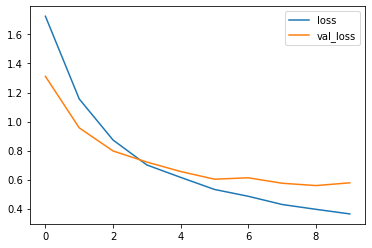

In [16]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

#Evaluating the Model

In [17]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [18]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 82%


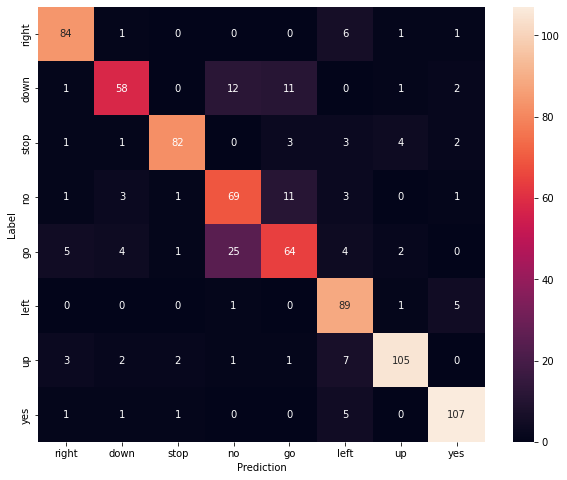

In [19]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

#Inferencing

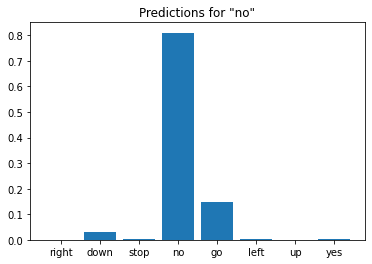

In [20]:
sample_file = data_dir/'no/01bb6a2a_nohash_0.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()